In [ ]:
!pip install snowflake-snowpark-python
!pip install snowflake-ml-python
#pip install googletrans

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 10.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11

### Setup Connection

In [ ]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd
# from googletrans import Translator
from snowflake.snowpark.functions import year, month, dayofmonth, dayofweek, to_varchar
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.snowpark.functions import col,sum as sum_, when, avg, median
from snowflake.snowpark.functions import count, lit, min, max
from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [ ]:
connection_parameters_2 = {
...    "account": "YEZEPEO-DATASCIENCE",
...    "user": "VNSHARED",
...    "password": "Columbia2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "MEIXI_DATA", # optional
...   "schema":"PUBLIC",  # optional
...  }

In [ ]:
new_session = Session.builder.configs(connection_parameters_2).create()

## Join Vespucio and equifax data

#### Joined Equifax and exported to Snowflake as FINAL_DATA_JOINED no need to run again

In [ ]:
# df_consolidated=new_session.sql('select * from PUBLIC.CONSOLIDATED_COPY')
# df_equifax = new_session.sql('select * from PUBLIC.EQUIFAX_COPY')

# # Finding Common columns
# common_cols = np.intersect1d(df_consolidated.columns, df_equifax.columns)

# # Printing common columns
# print ("Common Columns:",common_cols)

# df_con_equifax=df_consolidated.join(df_equifax.select('"RUT"', '"Score Equifax"'), on='"RUT"', how='left').drop(df_equifax['"FechaExtraccion"'])

# # Define the new column name for the second column
# new_column_name = 'FechaExtraccion'

# # Use withColumnRenamed to create a new DataFrame with the renamed column
# df_con_equifax_v = df_con_equifax.withColumnRenamed(df_con_equifax.columns[1], new_column_name)


# # Define the name of the table you want to create or overwrite in Snowflake
# table_name = 'FINAL_DATA_JOINED'

# # Write the DataFrame to a new table in Snowflake
# df_con_equifax_v.write.mode('overwrite').save_as_table(table_name)


In [ ]:
def dataset_shape(df):
    # Get the number of rows
    num_rows = df.count()
    # Get the number of columns
    num_columns = len(df.columns)
    # Shape of the DataFrame
    shape = (num_rows, num_columns)
    print("Shape of the given dataset", shape)

In [ ]:
df_final = new_session.sql('select * from PUBLIC.FINAL_DATA_JOINED')

In [ ]:
df_final.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"RUT"       |"FECHAEXTRACCION"  |"NumeroFolio"  |"FechaEmision"  |"FechaVencimiento"  |"FechaRegistro"  |"BusinessPartnerId"  |"CuentaContrato"  |"C

In [ ]:
dataset_shape(df_final)

Shape of the given dataset (482705441, 39)


In [ ]:
def data_prepocessing(df):
  df = df.with_column("YEAR_INVOICED", to_varchar(year(col('"FechaEmision"'))))\
                          .with_column("MONTH_INVOICED", to_varchar(month(col('"FechaEmision"'))))\
                          .with_column("DAY_OF_MONTH_INVOICED", to_varchar(dayofmonth(col('"FechaEmision"'))))\
                          .with_column("DAY_OF_WEEK_INVOICED", to_varchar(dayofweek(col('"FechaEmision"'))))\

  df = df.filter(col("RUT").is_not_null())
  df = df.filter(col('"TipoOperacion"')=='Peaje')
  df = df.withColumn('Unpaid', when(col('"StatusCompensacion"') == 'Pagada', 0).otherwise(1))


  result_customer_span= df.groupBy('"BusinessPartnerId"').agg(
      (max(col("YEAR_INVOICED")) - min(col("YEAR_INVOICED"))).alias("Customer_Lifespan")
  )


  df = df.filter((col('YEAR_INVOICED') == 2023)|(col('YEAR_INVOICED') == 2022)|(col('YEAR_INVOICED') == 2021))

  #dropping unique identifiers
  columns_to_drop_ui = ['"NumeroDocumento"', '"NumeroFolio"', '"RUT"','"CuentaContrato"','"StatusCompensacionTmp"','"FechaRegistro"',
                        '"ClaveReconciliacion"','"Cabecera_FechaHoraCreacion"','"Detalle_FechaHoraCreacion"','"Direccion"','"Nombre"','FECHAEXTRACCION',
                        '"DocumentoCompensacion"','"PosicionDocumento"']

  df = df.drop(*columns_to_drop_ui)

  #over 70% missing values
  columns_to_drop_mv=['"Cabecera_FechaHoraUltimaModificacion"', '"Detalle_FechaHoraUltimaModificacion"']
  df = df.drop(*columns_to_drop_mv)

  #redundant information- TipoOperacion contains the same information
  columns_to_drop3=['"OperacionPrincipal"','"OperacionParcial"','"TramoMora"','"StatusCompensacion"','"COMUNA"', '"REGION"', '"TramoMoraCliente"','"YEAR_INVOICED"',"DAY_OF_MONTH_INVOICED",'"TipoOperacion"']
  df = df.drop(*columns_to_drop3)


  df = df.with_column('"MaxCategoriaVehiculo"', col('"MaxCategoriaVehiculo"').astype("string"))


  schema = df.schema

  numerical_columns = []
  categorical_columns = []
  datetime_columns=[]

  # Iterate over the schema and check the data type of each column
  for field in schema.fields:
    #print(field.datatype)
    if isinstance(field.datatype, (IntegerType, FloatType, DoubleType, DecimalType, LongType)):
        numerical_columns.append(field.name)
    elif isinstance(field.datatype, StringType):
        categorical_columns.append(field.name)
    elif isinstance(field.datatype, (TimestampType, DateType)):
        datetime_columns.append(field.name)

  df = df.drop(*datetime_columns)

  df_with_lifespan=df.join(result_customer_span.select('"BusinessPartnerId"', "CUSTOMER_LIFESPAN"), on='"BusinessPartnerId"', how='left')

  # df_with_lifespan = df_with_lifespan.drop('"DiasCompensacion"')
  # df_with_lifespan = df_with_lifespan.drop('"BusinessPartnerId"')

  return df_with_lifespan


In [ ]:
df_processed= data_prepocessing(df_final)

In [ ]:
df_processed.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"BusinessPartnerId"  |"ImportePesos"  |"DiasCompensacion"  |"CIUDAD"  |"CantidadCuentasContrato"  |"CantidadVehiculos"  |"Inhabilitado"  |"Concesionaria"  |"TipoCliente"  |"TipoDocumento"  |"TipoProducto"  |"Score Equifax"  |"MONTH_INVOICED"  |"DAY_OF_WEEK_INVOICED"  |"UNPAID"  |"MaxCategoriaVehiculo"  |"CUSTOMER_LIFESPAN"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0010020680  

In [ ]:
# result_df = df.groupBy('"TipoOperacion"').agg(
#     (avg(col("UNPAID")) * 100).alias("Default_Percentage")
# )

# result_df.show()

In [ ]:
dataset_shape(df_processed)

Shape of the given dataset (102092363, 17)


In [ ]:
sampled_df = df_processed.sample(0.001)
dataset_shape(sampled_df)

Shape of the given dataset (102117, 17)


In [ ]:
pandas_df = sampled_df.to_pandas()

In [ ]:
pandas_df.head()

,BusinessPartnerId,ImportePesos,DiasCompensacion,CIUDAD,CantidadCuentasContrato,CantidadVehiculos,Inhabilitado,Concesionaria,TipoCliente,TipoDocumento,TipoProducto,Score Equifax,MONTH_INVOICED,DAY_OF_WEEK_INVOICED,UNPAID,MaxCategoriaVehiculo,CUSTOMER_LIFESPAN
0,0012800785,2892.0,NaN,CORDILLERA,1,7.0,Cliente Tag,AVN,Natural,Boleta,Tag,818.0,11,5,1,1.00000,7.0
1,0013834667,579.0,55.0,SANTIAGO,1,11.0,Cliente Tag,AVN,Natural,Boleta,Tag,905.0,9,1,0,1.00000,1.0
2,0010813358,1001.0,-11.0,SANTIAGO,3,8.0,Cliente Tag,TSC,Natural,Boleta,Tag,471.0,10,4,0,2.00000,18.0
3,0013653929,4.0,-14.0,SANTIAGO,1,1.0,Cliente Tag,AVN,Natural,Boleta,Tag,864.0,12,1,0,1.00000,4.0
4,0014019679,-2.0,-15.0,SANTIAGO,1,2.0,Cliente Tag,AVN,Natural,Boleta,Tag,1.0,8,1,0,1.00000,1.0


In [ ]:
# pandas_df.dropna(inplace=True)

In [ ]:
pandas_df.shape

(100817, 17)

In [ ]:
pandas_df.columns

Index(['BusinessPartnerId', 'ImportePesos', 'DiasCompensacion', 'CIUDAD',
       'CantidadCuentasContrato', 'CantidadVehiculos', 'Inhabilitado',
       'Concesionaria', 'TipoCliente', 'TipoDocumento', 'TipoProducto',
       'Score Equifax', 'MONTH_INVOICED', 'DAY_OF_WEEK_INVOICED', 'UNPAID',
       'MaxCategoriaVehiculo', 'CUSTOMER_LIFESPAN'],
      dtype='object')

In [ ]:
pandas_df['UNPAID'].value_counts(normalize=True)

UNPAID
0    0.872988
1    0.127012
Name: proportion, dtype: float64

In [ ]:
model_data=pandas_df.copy()

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
def train_test(df, target_column,test_size=0.2, random_state=42):

    #df.dropna(inplace=True)

    df.set_index(['BusinessPartnerId','DiasCompensacion'], inplace=True)

    numerical_cols_scaling= ['ImportePesos','Score Equifax','CantidadVehiculos','CantidadCuentasContrato','CUSTOMER_LIFESPAN']

    # Initialize scalers
    scaler_standard = StandardScaler()
    scaler_minmax = MinMaxScaler()

    # Apply standardization and normalization
    df[numerical_cols_scaling] = scaler_standard.fit_transform(df[numerical_cols_scaling])
    df[numerical_cols_scaling] = scaler_minmax.fit_transform(df[numerical_cols_scaling])

    # Convert categorical variables to dummy variables
    df_encoded = pd.get_dummies(df.drop(target_column, axis=1))
    df_encoded.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in df_encoded.columns]


    # Features and Target
    X = df_encoded
    y = df[target_column]

    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X,y, X_train, X_test, y_train, y_test


In [ ]:
def apply_threshold(probabilities, threshold):
    return (probabilities >= threshold).astype(int)

In [ ]:
def evaluate_model(model_classifier, X_train, X_test, y_train, y_test):

  # Initialize and train the XGBoost classifier

    # X_train_use=X_train.drop(columns=['BusinessPartnerId','DiasCompensacion'])
    # X_test_use=X_test.drop(columns=['BusinessPartnerId','DiasCompensacion'])


    # print(X_train_use)
    model = model_classifier
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)

    y_proba = model.predict_proba(X_test)


    prob_df = pd.DataFrame(y_proba, columns=['Prob_Class_{}'.format(i) for i in range(y_proba.shape[1])])

    prob_df.index = X_test.index


    # Compute ROC curve

    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    #   # Calculate the Youden's index
    j_scores = tpr - fpr
    j_ordered = sorted(zip(j_scores, thresholds))
    best_threshold = j_ordered[-1][1]

    y_pred_adjusted = apply_threshold(y_probs, best_threshold)

    print("Best Threshold:", best_threshold)

    # Compute AUC
    roc_auc = auc(fpr, tpr)

    # Calculating various performance metrics
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted, average='binary')  # Adjust 'binary' if you have a multi-class classification
    recall = recall_score(y_test, y_pred_adjusted, average='binary')
    f1 = f1_score(y_test, y_pred_adjusted, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

    # cv_results = model.cv(dtrain=data_dmatrix, params=params, nfold=5,
    #                 num_boost_round=50, early_stopping_rounds=10, metrics="auc",
    #                 as_pandas=True, seed=123)

#Output
    # print("AUC (mean): %f" % (cv_results["test-auc-mean"].tail(1)))

    # Printing the metrics
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Confusion Matrix:\n{conf_matrix}")



    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Returning the model and metrics in a dictionary
    return {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'predicted_prob':prob_df,
        'y_pred':y_pred,
        'y_test':y_test

    }

In [ ]:
X,y, X_train, X_test, y_train, y_test= train_test(model_data, 'UNPAID')

In [ ]:
X_test.isna().sum()

ImportePesos                      0
CantidadCuentasContrato           0
CantidadVehiculos               223
Score_Equifax                   510
CUSTOMER_LIFESPAN                 0
                               ... 
DAY_OF_WEEK_INVOICED_6            0
MaxCategoriaVehiculo_0_00000      0
MaxCategoriaVehiculo_1_00000      0
MaxCategoriaVehiculo_2_00000      0
MaxCategoriaVehiculo_3_00000      0
Length: 100, dtype: int64

In [ ]:
X_test.head()

,,ImportePesos,CantidadCuentasContrato,CantidadVehiculos,Score_Equifax,CUSTOMER_LIFESPAN,CIUDAD_AISEN,CIUDAD_ANTOFAGASTA,CIUDAD_ARAUCO,CIUDAD_ARICA,CIUDAD_AYSEN,...,DAY_OF_WEEK_INVOICED_1,DAY_OF_WEEK_INVOICED_2,DAY_OF_WEEK_INVOICED_3,DAY_OF_WEEK_INVOICED_4,DAY_OF_WEEK_INVOICED_5,DAY_OF_WEEK_INVOICED_6,MaxCategoriaVehiculo_0_00000,MaxCategoriaVehiculo_1_00000,MaxCategoriaVehiculo_2_00000,MaxCategoriaVehiculo_3_00000
BusinessPartnerId,DiasCompensacion,,,,,,,,,,,,,,,,,,,,,
0010334987,-14.0,0.341989,0.033898,0.003420,1.000000,0.944444,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
0010154233,-14.0,0.341724,0.016949,0.000071,0.780561,0.944444,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
0013433209,-15.0,0.341723,0.016949,0.000047,0.038076,0.222222,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
0011515217,15.0,0.349064,0.016949,0.000119,0.703407,0.777778,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
0013826817,NaN,0.342846,0.000000,0.000000,0.740481,0.111111,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False


Best Threshold: 0.12366222
Accuracy: 0.7129537790121008
Precision: 0.28130968622100955
Recall: 0.7986057319907048
F1 Score: 0.41606133979015336
Confusion Matrix:
[[12314  5268]
 [  520  2062]]


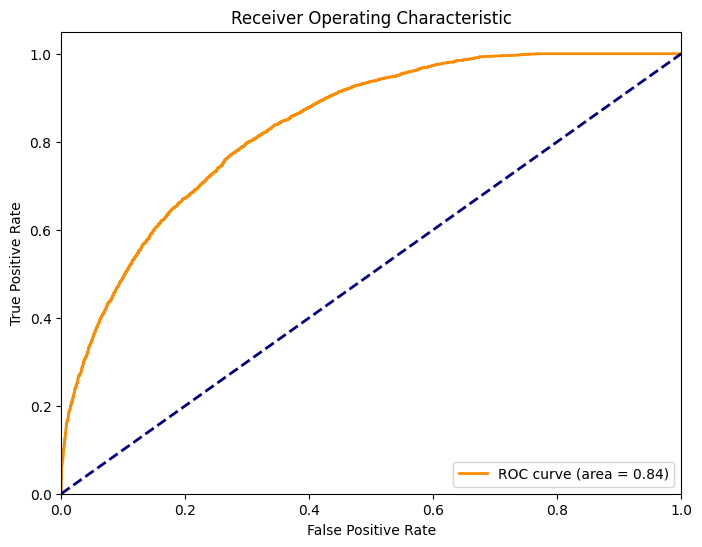

In [ ]:
results_xgb=evaluate_model(xgb.XGBClassifier(),X_train, X_test, y_train, y_test)

In [ ]:
from sklearn.feature_selection import SelectFromModel

# Create a selector object that will use the XGBoost model to identify features that have an importance
# of more than a threshold (here set automatically to mean importance as an example)
selector = SelectFromModel(results_xgb.get('model'), threshold='mean', prefit=True)

# Transform the dataset
X_transformed = selector.transform(X_train)

# Get the features that pass the threshold
selected_features = X.columns[selector.get_support()]

print("Selected features based on threshold:", selected_features)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features based on threshold: Index(['ImportePesos', 'CantidadCuentasContrato', 'CantidadVehiculos',
       'Score_Equifax', 'CUSTOMER_LIFESPAN', 'CIUDAD_LOS_ANDES',
       'CIUDAD_VALPARAISO', 'Inhabilitado_Cliente_Tag', 'Concesionaria_AVN',
       'TipoCliente_Juridico', 'TipoDocumento_Boleta',
       'TipoDocumento_Boleta_Exenta', 'TipoDocumento_Boleta_Infractora',
       'TipoDocumento_Nota_debito', 'MONTH_INVOICED_11', 'MONTH_INVOICED_12',
       'DAY_OF_WEEK_INVOICED_2', 'DAY_OF_WEEK_INVOICED_4',
       'DAY_OF_WEEK_INVOICED_5', 'MaxCategoriaVehiculo_1_00000'],
      dtype='object')


In [ ]:
xgb_prob=results_xgb.get('predicted_prob')
xgb_pred=results_xgb.get('y_pred')
xgb_actual=results_xgb.get('y_test')
xgb_actual=xgb_actual.reset_index()
xgb_prob.reset_index(inplace=True)
xgb_prob['Predicted Default']=xgb_pred
xgb_prob['Actual_Default'] = xgb_actual['UNPAID']

In [ ]:
xgb_prob

,BusinessPartnerId,DiasCompensacion,Prob_Class_0,Prob_Class_1,Predicted Default,Actual_Default
0,0010334987,-14.0,0.999846,0.000154,0,0
1,0010154233,-14.0,0.909403,0.090597,0,0
2,0013433209,-15.0,0.999751,0.000249,0,0
3,0011515217,15.0,0.827199,0.172801,0,0
4,0013826817,NaN,0.137807,0.862193,1,1
...,...,...,...,...,...,...
20159,0010619151,-9.0,0.970837,0.029163,0,0
20160,0011725998,-14.0,0.971391,0.028609,0,0
20161,0012193866,3.0,0.942889,0.057111,0,0
20162,0011264701,341.0,0.861394,0.138606,0,0


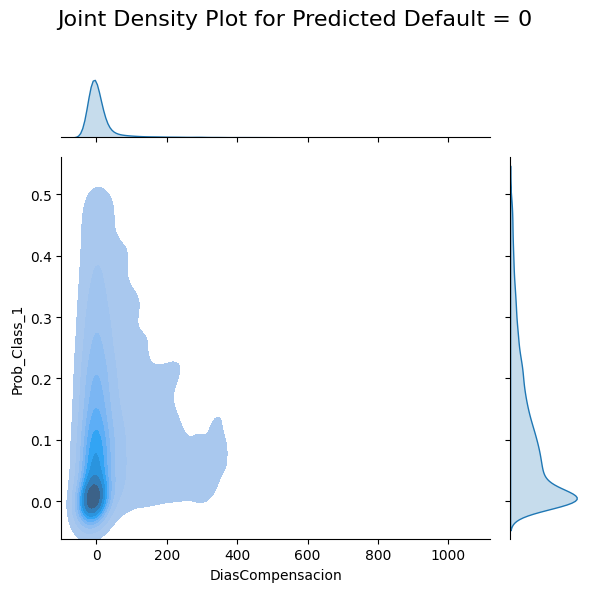

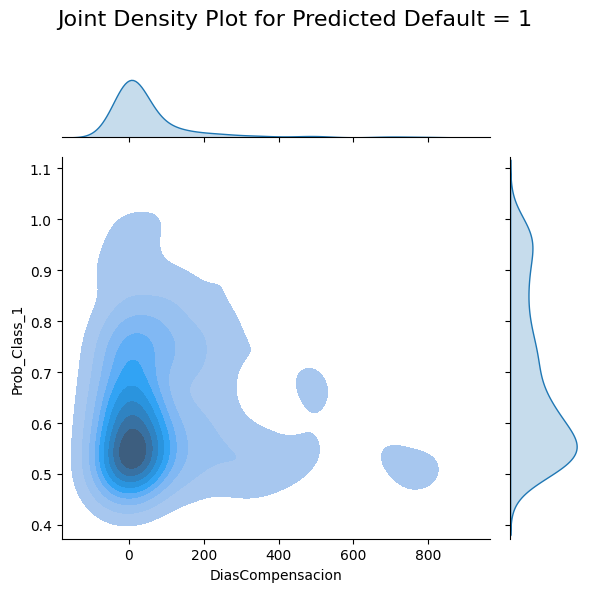

In [ ]:
# Filtering data based on 'Predicted Default'
df_default_0 = xgb_prob[xgb_prob['Predicted Default'] == 0]
df_default_1 = xgb_prob[xgb_prob['Predicted Default'] == 1]

# Plotting Joint Density Plot for Predicted Default = 0
g0 = sns.jointplot(x='DiasCompensacion', y='Prob_Class_1', data=df_default_0, kind="kde", fill=True)
g0.fig.suptitle('Joint Density Plot for Predicted Default = 0', fontsize=16)
g0.fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title
plt.show()

# Plotting Joint Density Plot for Predicted Default = 1
g1 = sns.jointplot(x='DiasCompensacion', y='Prob_Class_1', data=df_default_1, kind="kde", fill=True)
g1.fig.suptitle('Joint Density Plot for Predicted Default = 1', fontsize=16)
g1.fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


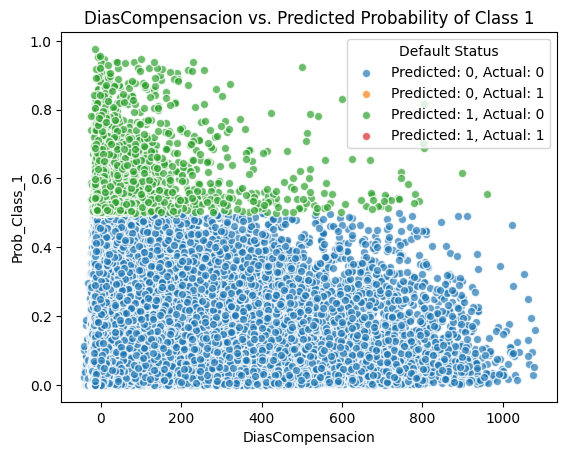

In [ ]:
fig, ax = plt.subplots()

# Scatter plot differentiating predicted and actual defaults
for (predicted, actual), group in xgb_prob.groupby(['Predicted Default', 'Actual_Default']):
    label = f'Predicted: {predicted}, Actual: {actual}'
    ax.scatter(group['DiasCompensacion'], group['Prob_Class_1'], label=label, alpha=0.7, edgecolors='w')

# Handling NaN values in 'DiasCompensacion' if any
# df.dropna(subset=['DiasCompensacion'], inplace=True)

# Plot decorations
ax.set_xlabel('DiasCompensacion')
ax.set_ylabel('Prob_Class_1')
ax.set_title('DiasCompensacion vs. Predicted Probability of Class 1')
ax.legend(title='Default Status')
plt.show()

<ipython-input-40-9ad335759328>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjusts plot parameters to give some padding and avoid overlap


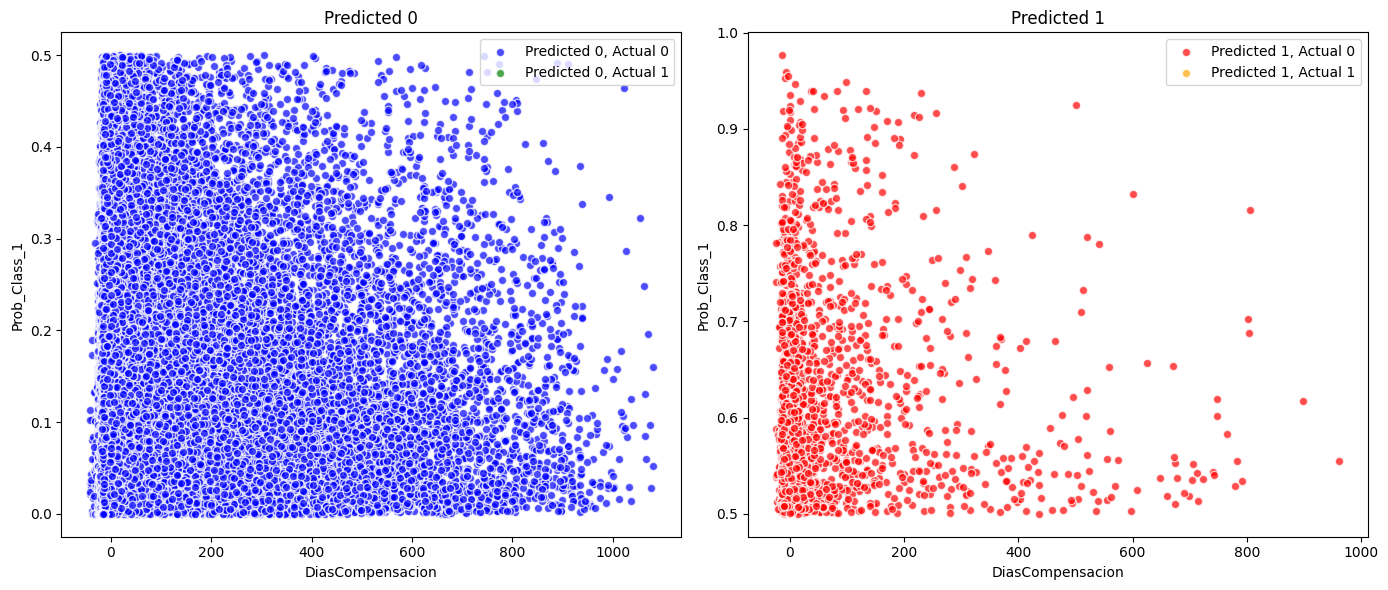

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns of subplots

# Colors for clarity
colors = {
    (0, 0): 'blue',     # Predicted 0, Actual 0
    (0, 1): 'green',    # Predicted 0, Actual 1
    (1, 0): 'red',      # Predicted 1, Actual 0
    (1, 1): 'orange'    # Predicted 1, Actual 1
}

# Plot 1: Predicted 0, Actual 0 and Predicted 0, Actual 1
for (predicted, actual), color in [((0, 0), colors[(0, 0)]), ((0, 1), colors[(0, 1)])]:
    group = xgb_prob[(xgb_prob['Predicted Default'] == predicted) & (xgb_prob['Actual_Default'] == actual)]
    ax[0].scatter(group['DiasCompensacion'], group['Prob_Class_1'], label=f'Predicted {predicted}, Actual {actual}', color=color, alpha=0.7, edgecolors='w')

ax[0].set_title('Predicted 0')
ax[0].set_xlabel('DiasCompensacion')
ax[0].set_ylabel('Prob_Class_1')
ax[0].legend()

# Plot 2: Predicted 1, Actual 0 and Predicted 1, Actual 1
for (predicted, actual), color in [((1, 0), colors[(1, 0)]), ((1, 1), colors[(1, 1)])]:
    group = xgb_prob[(xgb_prob['Predicted Default'] == predicted) & (xgb_prob['Actual_Default'] == actual)]
    ax[1].scatter(group['DiasCompensacion'], group['Prob_Class_1'], label=f'Predicted {predicted}, Actual {actual}', color=color, alpha=0.7, edgecolors='w')

ax[1].set_title('Predicted 1')
ax[1].set_xlabel('DiasCompensacion')
ax[1].set_ylabel('Prob_Class_1')
ax[1].legend()

# Show plot
plt.tight_layout()  # Adjusts plot parameters to give some padding and avoid overlap
plt.show()



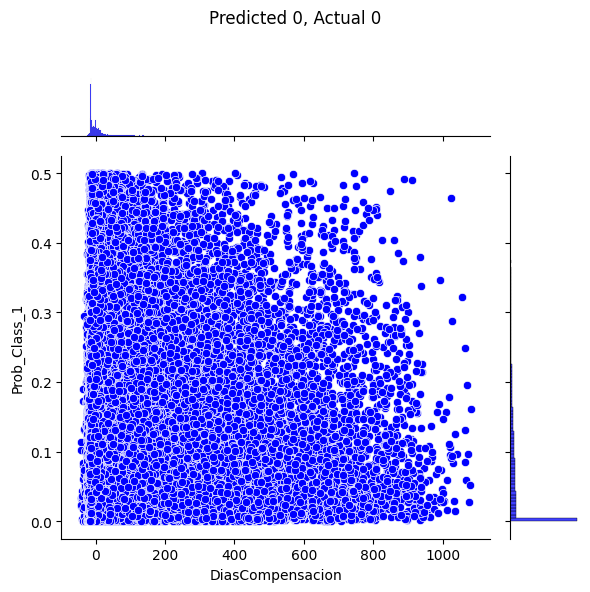

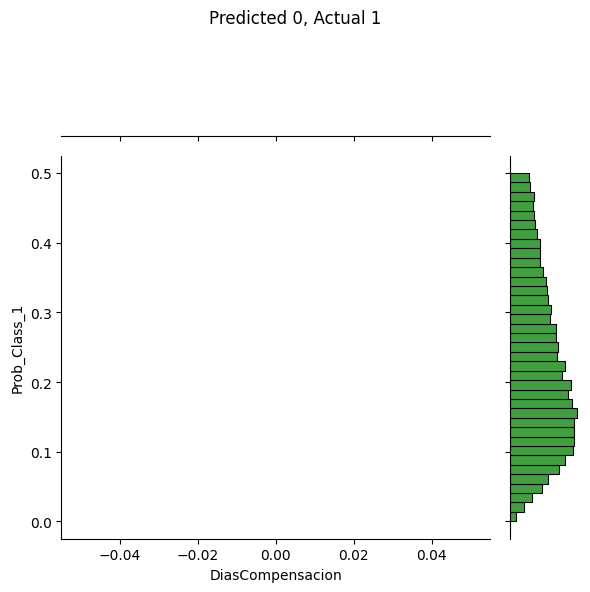

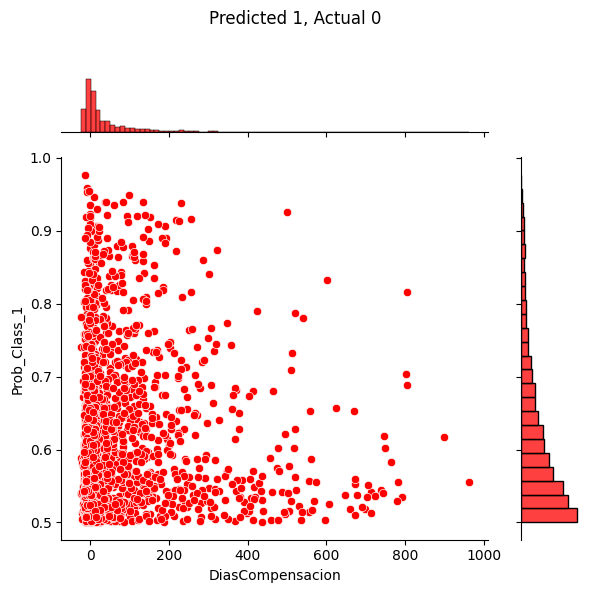

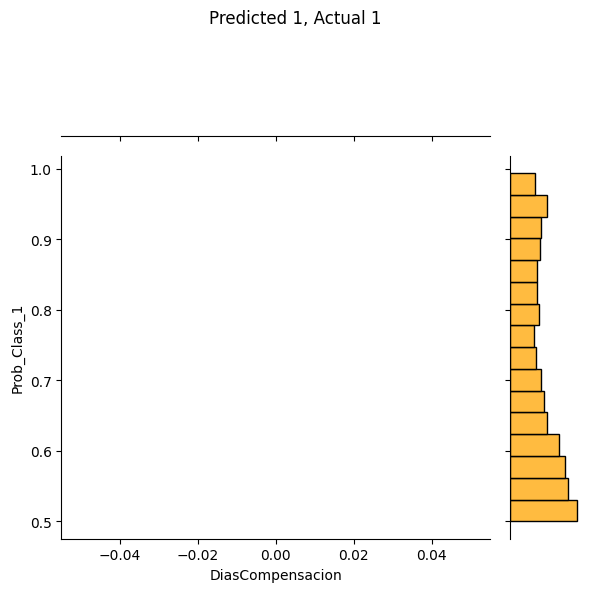

In [ ]:
# Define the groups to plot
groups = [(0, 0), (0, 1), (1, 0), (1, 1)]
group_labels = ['Predicted 0, Actual 0', 'Predicted 0, Actual 1', 'Predicted 1, Actual 0', 'Predicted 1, Actual 1']
colors = ['blue', 'green', 'red', 'orange']  # Define colors for visual distinction

for (predicted, actual), label, color in zip(groups, group_labels, colors):
    # Filter data for the current group
    group_data = xgb_prob[(xgb_prob['Predicted Default'] == predicted) & (xgb_prob['Actual_Default'] == actual)]

    if not group_data.empty:
        # Create a jointplot for the current group
        g = sns.jointplot(x='DiasCompensacion', y='Prob_Class_1', data=group_data,
                          kind="scatter", color=color, height=6, space=0.2)
        g.fig.suptitle(label)  # Add a title to each figure
        g.fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for title
        plt.show()  # Display the plot



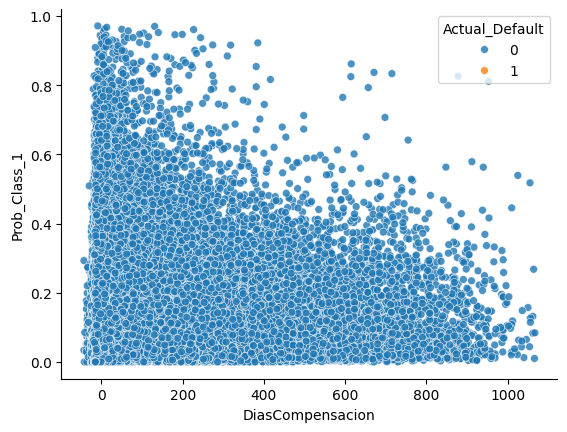

In [ ]:
# @title DiasCompensacion vs Prob_Class_0

sns.scatterplot(data=xgb_prob, x='DiasCompensacion', y='Prob_Class_1', hue='Actual_Default', s=32, alpha=0.8)

# Optional: Adjust the legend and the axis spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

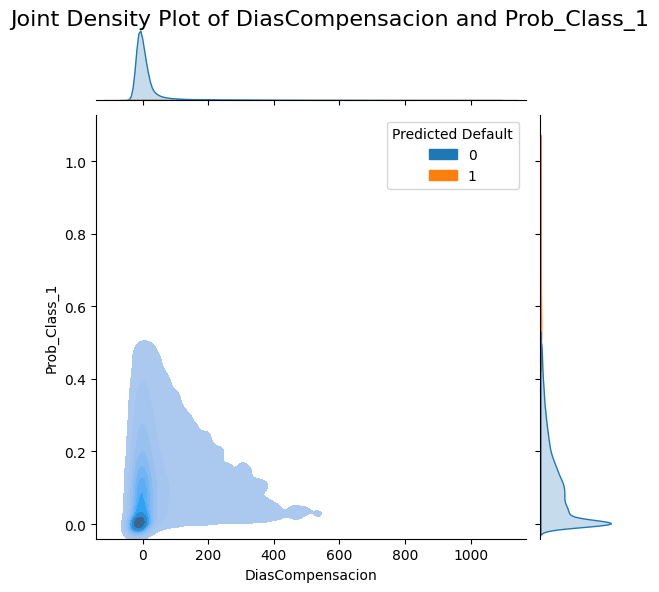

In [ ]:
# Creating the joint density plot
sns.jointplot(x="DiasCompensacion", y="Prob_Class_1", data=xgb_prob, kind="kde", fill=True,hue='Predicted Default')

# Additional customization
plt.suptitle('Joint Density Plot of DiasCompensacion and Prob_Class_1', fontsize=16)
plt.subplots_adjust(top=0.95)  # Adjust the title to not overlap with plots

# Display the plot
plt.show()

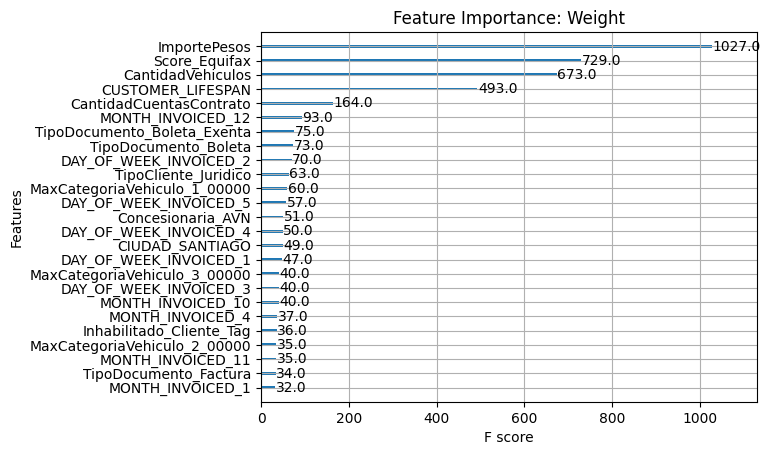

In [ ]:
# Plotting the feature importance for 'weight'
xgb.plot_importance(results_xgb.get('model'), importance_type='weight', title='Feature Importance: Weight', max_num_features=25)
plt.show()

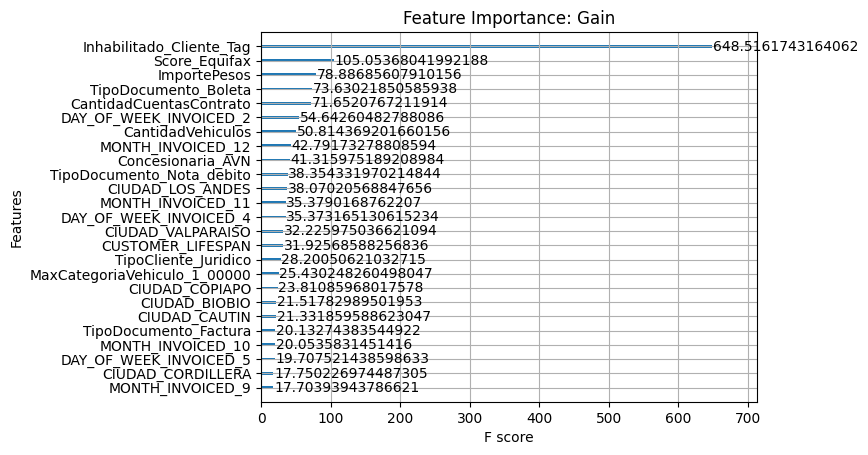

In [ ]:
# Plotting the feature importance for 'gain'
xgb.plot_importance(results_xgb.get('model'), importance_type='gain', title='Feature Importance: Gain', max_num_features=25)
plt.show()

In [ ]:
results_xgb.get('predicted_prob')

,BusinessPartnerId,DiasCompensacion,Prob_Class_0,Prob_Class_1,Predicted Default,Actual_Default
0,0010844015,-1.0,0.981923,0.018077,0,0
1,0013828380,NaN,0.617712,0.382288,0,1
2,0014114295,-11.0,0.686811,0.313189,0,0
3,0011423484,NaN,0.606570,0.393430,0,1
4,0013238380,-12.0,0.612091,0.387909,0,0
...,...,...,...,...,...,...
204328,0012633980,-10.0,0.776230,0.223770,0,0
204329,0013919934,-14.0,0.999940,0.000060,0,0
204330,0010502542,-15.0,0.999931,0.000069,0,0
204331,0011348338,NaN,0.859643,0.140357,0,1


In [ ]:


# Compute ROC curve
fpr, tpr, thresholds = roc_curve(results_xgb.get('y_test'), results_xgb.get('predicted_prob')[''])

# Compute AUC
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

ValueError: y should be a 1d array, got an array of shape (204333, 6) instead.

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
results_randomforest=evaluate_model(RandomForestClassifier(),X_train, X_test, y_train, y_test)

Accuracy: 0.88552378054964
Precision: 0.5696242008420396
Recall: 0.15564550489987217
F1 Score: 0.2444868319780477
Confusion Matrix:
[[170990   2760]
 [ 19817   3653]]


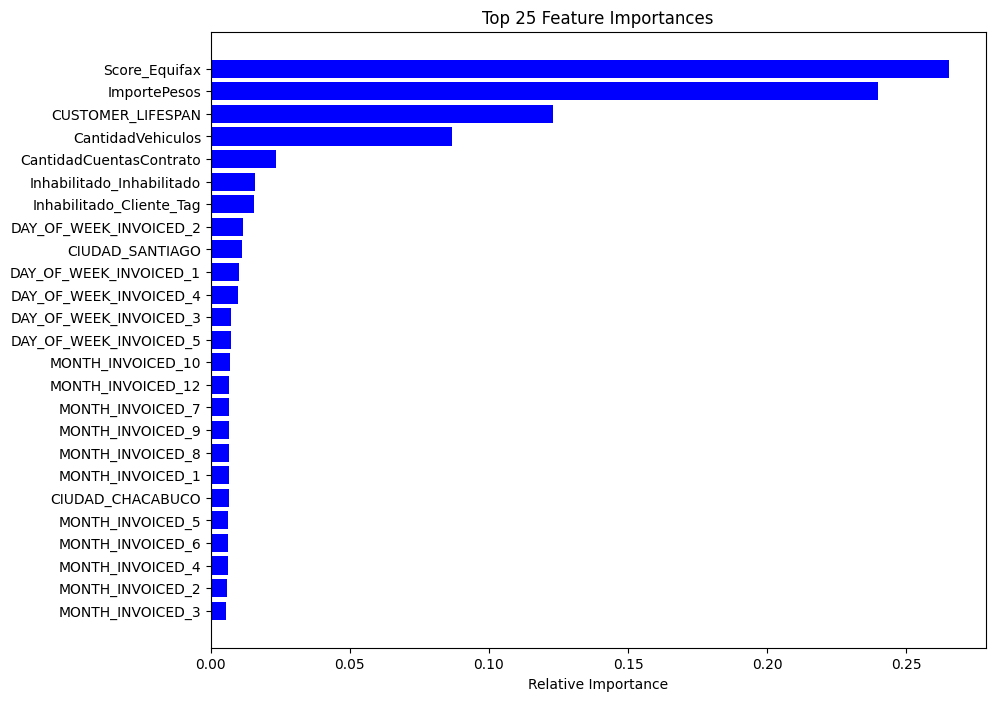

In [ ]:
importances = results_randomforest.get('model').feature_importances_
indices = np.argsort(importances)[-25:]  # Top 25 features

# Plot the feature importances of the forest
plt.figure(figsize=(10, 8))
plt.title('Top 25 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
results_lgbm=evaluate_model(lgb.LGBMClassifier(),X_train, X_test, y_train, y_test)

[LightGBM] [Info] Number of positive: 94214, number of negative: 694665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.437364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 914
[LightGBM] [Info] Number of data points in the train set: 788879, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119428 -> initscore=-1.997861
[LightGBM] [Info] Start training from score -1.997861
Accuracy: 0.8896866443565561
Precision: 0.7297587131367292
Recall: 0.11597784405624201
F1 Score: 0.20014705882352943
Confusion Matrix:
[[172742   1008]
 [ 20748   2722]]


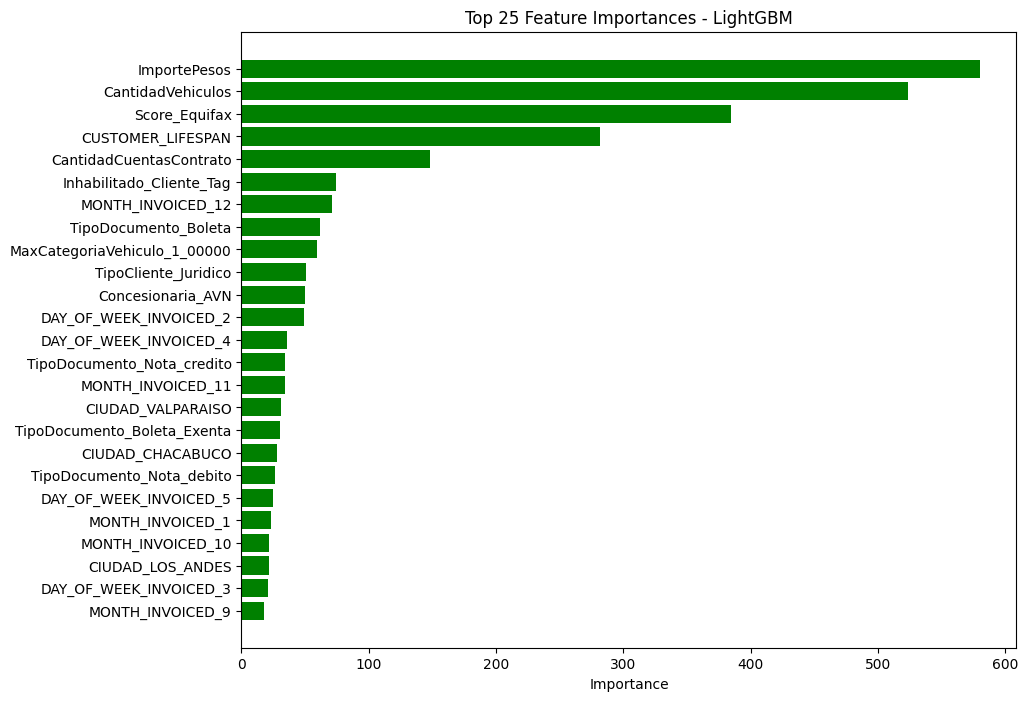

In [ ]:
# Get feature importances
importances = results_lgbm.get('model').feature_importances_
feature_names = X_train.columns
feature_imports = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imports = feature_imports.sort_values(by='Importance', ascending=False).head(25)  # top 25 features

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_imports['Feature'], feature_imports['Importance'], color='green')
plt.xlabel('Importance')
plt.title('Top 25 Feature Importances - LightGBM')
plt.gca().invert_yaxis()  # Invert y axis to have the most important at the top
plt.show()


In [ ]:
lgbm_prob=results_lgbm.get('predicted_prob')
lgbm_pred=results_lgbm.get('y_pred')
lgbm_actual=results_lgbm.get('y_test')
lgbm_actual=lgbm_actual.reset_index()
lgbm_prob.reset_index(inplace=True)
lgbm_prob['Predicted Default']=xgb_pred
lgbm_prob['Actual_Default'] = lgbm_actual['UNPAID']

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


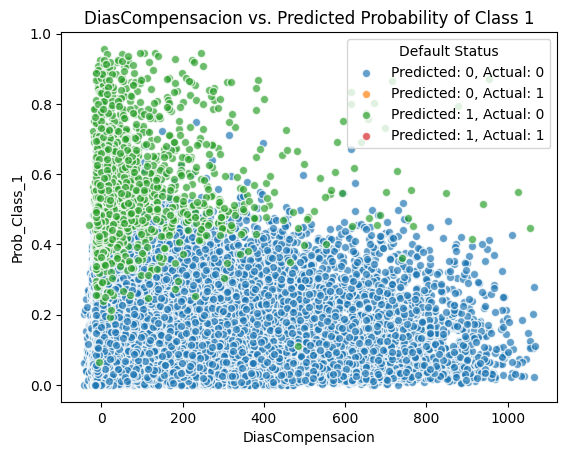

In [ ]:
fig, ax = plt.subplots()

# Scatter plot differentiating predicted and actual defaults
for (predicted, actual), group in lgbm_prob.groupby(['Predicted Default', 'Actual_Default']):
    label = f'Predicted: {predicted}, Actual: {actual}'
    ax.scatter(group['DiasCompensacion'], group['Prob_Class_1'], label=label, alpha=0.7, edgecolors='w')

# Handling NaN values in 'DiasCompensacion' if any
# lgbm_prob.dropna(subset=['DiasCompensacion'], inplace=True)

# Plot decorations
ax.set_xlabel('DiasCompensacion')
ax.set_ylabel('Prob_Class_1')
ax.set_title('DiasCompensacion vs. Predicted Probability of Class 1')
ax.legend(title='Default Status')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
results_logit=evaluate_model(LogisticRegression(random_state=0,max_iter=200,solver='sag'),X_train, X_test, y_train, y_test)

Accuracy: 0.8850623668999087
Precision: 0.7213024282560706
Recall: 0.055688112484022154
F1 Score: 0.10339371885135669
Confusion Matrix:
[[173245    505]
 [ 22163   1307]]


<Figure size 800x500 with 0 Axes>

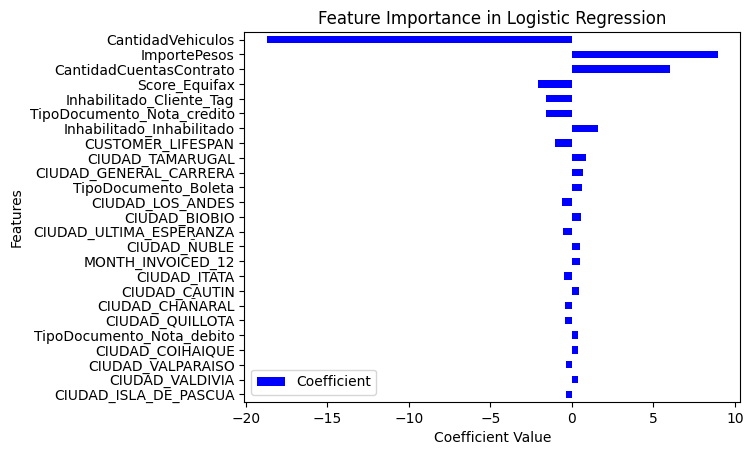

In [ ]:
# Extract coefficients
coefficients = results_logit.get('model').coef_[0]  # Get the coefficients corresponding to each feature
features = X_train.columns  # Feature names

# Create a DataFrame of features and their corresponding coefficients
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})

# Sort the features by the absolute value of their coefficients
feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False).head(25)

# Plotting
plt.figure(figsize=(8, 5))
feature_importance.sort_values(by='Absolute Coefficient').plot.barh(x='Feature', y='Coefficient', color='blue')
plt.title('Feature Importance in Logistic Regression')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
X.head()

,,ImportePesos,CantidadCuentasContrato,CantidadVehiculos,Score_Equifax,CUSTOMER_LIFESPAN,CIUDAD__,CIUDAD_AISEN,CIUDAD_ANTARTICA,CIUDAD_ANTOFAGASTA,CIUDAD_ARAUCO,...,DAY_OF_WEEK_INVOICED_1,DAY_OF_WEEK_INVOICED_2,DAY_OF_WEEK_INVOICED_3,DAY_OF_WEEK_INVOICED_4,DAY_OF_WEEK_INVOICED_5,DAY_OF_WEEK_INVOICED_6,MaxCategoriaVehiculo_0_00000,MaxCategoriaVehiculo_1_00000,MaxCategoriaVehiculo_2_00000,MaxCategoriaVehiculo_3_00000
BusinessPartnerId,DiasCompensacion,,,,,,,,,,,,,,,,,,,,,
0013867255,90.0,0.120431,0.000000,0.000047,0.031062,0.166667,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
0010169172,-16.0,0.119254,0.016949,0.000119,0.943888,1.000000,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
0012011570,NaN,0.177722,0.000000,0.000047,0.000000,0.611111,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
0010653204,50.0,0.119942,0.016949,0.000332,0.006012,0.944444,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
0010631888,-15.0,0.121503,0.000000,0.000404,0.666333,0.944444,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False


In [ ]:
y

BusinessPartnerId  DiasCompensacion
0013867255          90.0               0
0010169172         -16.0               0
0012011570         NaN                 1
0010653204          50.0               0
0010631888         -15.0               0
                                      ..
0010273843         -3.0                0
                   -3.0                0
0010277305          0.0                0
                    0.0                0
                    0.0                0
Name: UNPAID, Length: 102437, dtype: int8

In [ ]:
logit_data=model_data.copy()
logit_data.drop(columns=['BusinessPartnerId','DiasCompensacion','CIUDAD','TipoDocumento'])

,ImportePesos,CantidadCuentasContrato,CantidadVehiculos,Inhabilitado,Concesionaria,TipoCliente,TipoProducto,Score Equifax,MONTH_INVOICED,DAY_OF_WEEK_INVOICED,UNPAID,MaxCategoriaVehiculo,CUSTOMER_LIFESPAN
0,-5.0,1,5.0,Cliente Tag,AVN,Natural,Tag,683.0,10,4,0,1.00000,18.0
1,3.0,1,4.0,Cliente Tag,AVN,Natural,Tag,966.0,4,4,0,1.00000,6.0
2,-3.0,1,1.0,Cliente Tag,AVN,Natural,Tag,56.0,8,2,0,1.00000,4.0
3,662.0,1,4.0,Cliente Tag,TSC,Natural,Tag,754.0,10,5,0,1.00000,11.0
4,1884.0,2,4.0,Cliente Tag,TSC,Natural,Tag,563.0,5,4,0,1.00000,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101901,2158.0,1,1.0,Cliente Tag,AVN,Natural,Tag,799.0,7,5,0,1.00000,3.0
101902,759.0,2,15.0,Cliente Tag,AVN,Juridico,Tag,999.0,7,4,0,3.00000,17.0
101903,11554.0,1,1.0,Cliente Tag,AVN,Natural,Tag,801.0,9,2,1,1.00000,3.0
101904,4.0,2,5.0,Cliente Tag,AVN,Natural,Tag,810.0,10,4,0,1.00000,17.0


In [ ]:
y_logit =logit_data['UNPAID']
X_logit=logit_data.drop('UNPAID', axis=1)

In [ ]:
# Select features and target
X_logit = pd.get_dummies(X_logit, drop_first=True)
y_logit = y_logit



In [ ]:
# Add a constant to the features for the intercept
X_const = sm.add_constant(X_logit)

In [ ]:
# Fit the logistic regression model
model = sm.Logit(y_logit, X_const)
result = model.fit()

# Display the summary of the model
print(result.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
results_catboost=evaluate_model(CatBoostClassifier(),X_train, X_test, y_train, y_test)

Learning rate set to 0.066447
0:	learn: 0.6340676	total: 21ms	remaining: 21s
1:	learn: 0.5700339	total: 63.4ms	remaining: 31.6s
2:	learn: 0.5278876	total: 112ms	remaining: 37.3s
3:	learn: 0.4934948	total: 137ms	remaining: 34s
4:	learn: 0.4678320	total: 175ms	remaining: 34.7s
5:	learn: 0.4435070	total: 217ms	remaining: 36s
6:	learn: 0.4250419	total: 252ms	remaining: 35.7s
7:	learn: 0.4098309	total: 274ms	remaining: 34s
8:	learn: 0.3976983	total: 301ms	remaining: 33.1s
9:	learn: 0.3864161	total: 375ms	remaining: 37.1s
10:	learn: 0.3764010	total: 414ms	remaining: 37.2s
11:	learn: 0.3615948	total: 438ms	remaining: 36.1s
12:	learn: 0.3546748	total: 462ms	remaining: 35.1s
13:	learn: 0.3482793	total: 485ms	remaining: 34.2s
14:	learn: 0.3425446	total: 525ms	remaining: 34.4s
15:	learn: 0.3386496	total: 549ms	remaining: 33.8s
16:	learn: 0.3352190	total: 576ms	remaining: 33.3s
17:	learn: 0.3318104	total: 599ms	remaining: 32.7s
18:	learn: 0.3286436	total: 632ms	remaining: 32.6s
19:	learn: 0.323447

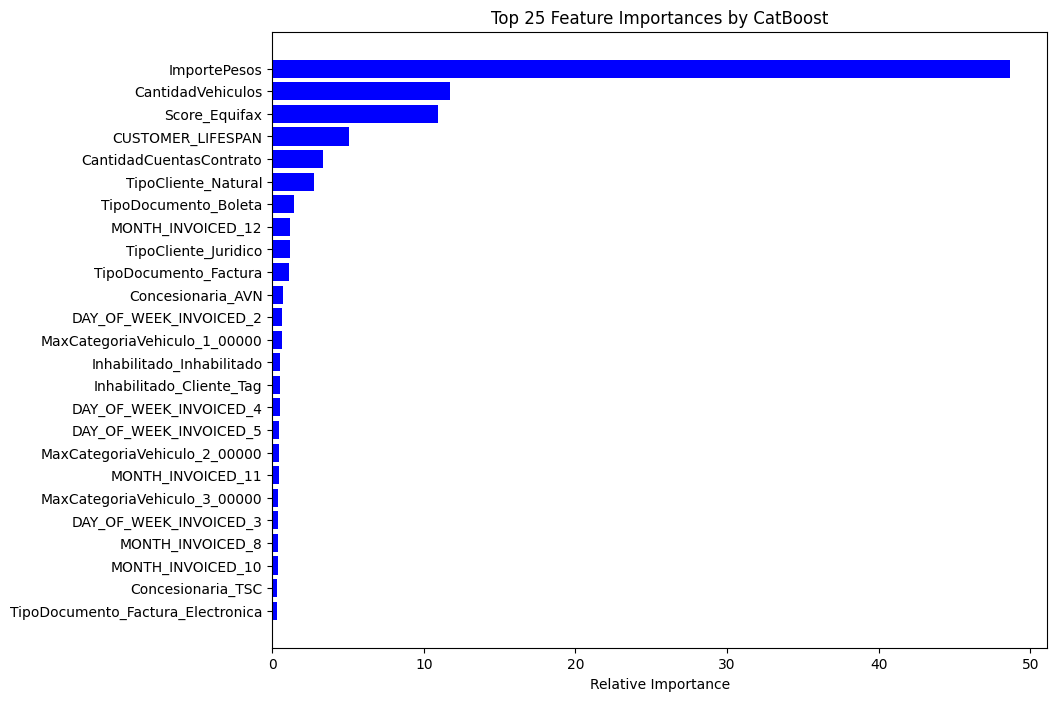

In [ ]:
# Extract feature importances
feature_importances = results_catboost.get('model').get_feature_importance()
feature_names = X_train.columns

# Sort the feature importances in descending order and get the indices
indices = np.argsort(feature_importances)[::-1]

# Limit to top 25 features
top_indices = indices[:25]

# Create a figure to plot
plt.figure(figsize=(10, 8))
plt.title('Top 25 Feature Importances by CatBoost')
plt.barh(range(len(top_indices)), feature_importances[top_indices], color='b', align='center')
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important at the top
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

# Assuming 'B' and 'C' are categorical and converted to type 'category'
pandas_df['CIUDAD'] = pandas_df['CIUDAD'].astype('category')
pandas_df['MaxCategoriaVehiculo'] = pandas_df['MaxCategoriaVehiculo'].astype('category')

# Create a contingency table
contingency_table = pd.crosstab(pandas_df['CIUDAD'], pandas_df['MaxCategoriaVehiculo'])

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square test p-value:", p)

Chi-square test p-value: 0.0


In [ ]:
new_session.close()